In [1]:
!wandb login

wandb: Currently logged in as: s-li2022 (sli2024). Use `wandb login --relogin` to force relogin


In [2]:
import os, gc, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import librosa

from tqdm.notebook import tqdm
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
import torch.nn.functional as F

import transformers
from transformers import ASTConfig, ASTFeatureExtractor, ASTModel

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score

from time import time

import wandb

In [3]:
def get_logger(log_file='log.txt'):
    import logging
    import sys
    
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(message)s')
    # Logging to file
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    # Logging to console
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
    return logger

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def wandb_init(project_name, run_name, config):
    config_dict = {
        k: v for k, v in config.__dict__.items() if not k.startswith('_') and not callable(v) and k != 'copy'
    }
    run = wandb.init(project=project_name, name=run_name, config=config_dict)
    return run

In [4]:
DRIVE_FOLDER = "." #"/content/drive/MyDrive/Colab Notebooks"
KEEP_COLS = ['category_number', 'common_name', 'audio_length', 'type', 'remarks', 'quality', 'scientific_name', 'mp3_link', 'region']

class Config:
    # path
    dataset_dir = f"{DRIVE_FOLDER}/Audio_XenoCanto/Audio_XenoCanto"
    # labels_list = f"{DRIVE_FOLDER}/xeno_labels.csv"
    model_name = "ast_pretrain_15epoch"
    backbone_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
    # number of classes in the dataset
    n_classes = 397 
    # Audio parameters
    audio_sr = 16000 #Hz
    segment_length = 10  #s
    fft_window = 0.025 #s
    hop_window_length = 0.01 #s
    n_mels = 128
    low_cut = 1000 #Hz
    high_cut = 8000 #Hz
    top_db = 100
    # Training parameters
    batch_size = 8
    num_workers = 0
    n_splits = 5
    log_dir = f"{DRIVE_FOLDER}/training_logs"
    max_lr = 1e-5
    epochs = 10
    weight_decay = 0.01
    lr_final_div = 1000
    amp = True
    grad_accum_steps = 1
    max_grad_norm = 1e7
    print_epoch_freq = 1
    print_freq = 200
    # model parameters
    n_decoder_layers = 6
    n_decoder_heads = 12
    ff_dim_decoder = 2048
    # seed
    random_seed = 2046
    
    @classmethod
    def copy(cls):
        new_class = type('CustomConfig', (cls,), {k: v for k, v in cls.__dict__.items() if not k.startswith('__') and not callable(v)})
        return new_class
    
config = Config.copy()

if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

seed_everything(config.random_seed)

cuda


In [5]:
df_audio_meta = pd.read_csv(f"{config.dataset_dir}/metadata.csv", nrows=None)
df_audio_meta = df_audio_meta.dropna().reset_index(drop=True)

# Filter out files that do not exist
df_audio_meta['file_exists'] = df_audio_meta['file_name'].apply(lambda x: os.path.exists(f"{config.dataset_dir}/{x}"))
df_audio_meta = df_audio_meta[df_audio_meta['file_exists']].reset_index(drop=True)

# parse scientific names
df_audio_meta['scientific_name'] = df_audio_meta['scientific_name'].apply(lambda x: "_".join(x.split(" ")))

# drop species with less than 2 samples
class_counts = df_audio_meta['scientific_name'].value_counts()
print(f"Number of classes with less than 2 samples: {len(class_counts[class_counts < 2])}")

df_audio_meta = df_audio_meta[df_audio_meta['scientific_name'].isin(class_counts[class_counts > 1].index)].copy().reset_index(drop=True)

# encode scientific names to label ids
label_ids_list = df_audio_meta['scientific_name'].unique().tolist()
label_ids_list.sort()
label_to_id = {label: i for i, label in enumerate(label_ids_list)}
df_audio_meta['species_id'] = df_audio_meta['scientific_name'].map(label_to_id)

# save the label mapping
label_mapping = pd.DataFrame(label_to_id.items(), columns=['scientific_name', 'species_id'])
label_mapping.to_csv(f"{config.dataset_dir}/label_mapping.csv", index=False)

# drop samples with no labels
df_audio_meta.dropna(subset=['species_id'], inplace=True)
df_audio_meta.reset_index(drop=True, inplace=True)
df_audio_meta['species_id'] = df_audio_meta['species_id'].astype(int)

print(f"Number of classes in dataset: {df_audio_meta['species_id'].nunique()}")
print(f'Number of samples:', len(df_audio_meta))

# save the number of classes in the config
config.n_classes = df_audio_meta['species_id'].nunique()

df_audio_meta.head(5)

Number of classes with less than 2 samples: 72
Number of classes in dataset: 728
Number of samples: 11171


,file_name,category_number,common_name,audio_length,type,remarks,quality,mp3_link,scientific_name,region,file_exists,species_id
0,data/XC228210-Blue-crowned_Manakin_B_9369_0.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,329
1,data/XC228210-Blue-crowned_Manakin_B_9369_1.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,329
2,data/XC200163-PIPCOR03_0.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329
3,data/XC200163-PIPCOR03_1.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329
4,data/XC200163-PIPCOR03_2.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329


In [6]:
class BirdDecoder(nn.Module):
    def __init__(self, enc_dim, d_dim=768, n_layers=2, n_heads=6, ff_dim=3072, dropout=0.0):
        super().__init__()
        
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_dim,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu', 
            batch_first=True
        )
        
        self.decoder_embed = nn.Linear(enc_dim, d_dim, bias=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=n_layers)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, d_dim)).to(DEVICE)
        
        # random initialization of position embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, d_dim)).to(DEVICE)
        
    def forward(self, tgt, memory, mask_indices):
        
        # tgt: (batch_size, seq_len, enc_dim) sequence of image patches
        # memory: (batch_size, seq_len, enc_dim) embeddings from encoder
        # position_embedding: (seq_len, enc_dim) positional embedding for each patch
        # mask_indices: (batch_size, n_mask_indices) indices of patches to mask
        
        batch_size, seq_len, d_dim = tgt.size()
        
        # Embed and add position embedding
        pos_embedding = self.pos_embedding.expand(batch_size, seq_len, -1)
        tgt = self.decoder_embed(tgt) + pos_embedding
        
        # Mask tokens
        mask_tokens = self.mask_token.repeat(batch_size, mask_indices.size(1), 1)
        tgt.scatter_(1, mask_indices.unsqueeze(-1).expand(-1, -1, d_dim), mask_tokens)
        memory.scatter_(1, mask_indices.unsqueeze(-1).expand(-1, -1, d_dim), mask_tokens)
        
        tgt_key_padding_mask = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=tgt.device)
        tgt_key_padding_mask.scatter_(1, mask_indices, True)
        
        mem_key_padding_mask = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=tgt.device)
        mem_key_padding_mask.scatter_(1, mask_indices, True)
        
        # Decode
        decoded_tokens = self.decoder(
            tgt, 
            memory, 
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=mem_key_padding_mask
        )
        
        return decoded_tokens
    
    
class BirdEncoder(nn.Module):
    def __init__(self, backbone_name):
        super().__init__()
        
        backbone_config = ASTConfig.from_pretrained(backbone_name)
        self.encoder_model = ASTModel.from_pretrained(backbone_name, config=backbone_config)
        self.hidden_size = self.encoder_model.config.hidden_size

    def forward(self, x):
        
        # x: (batch_size, t_len, f_len) input spectrograms
        # output: (batch_size, seq_len, enc_dim) embeddings
        
        spec_embeddings = self.encoder_model.embeddings(x)
        encoder_outputs = self.encoder_model.encoder(spec_embeddings)
        
        return encoder_outputs.last_hidden_state, spec_embeddings
    
    
class BirdASTForPretrain(nn.Module):

    def __init__(self, backbone_name, mask_ratio=0.75, d_dim=768, n_layers=2, n_heads=6, ff_dim=3072, dropout=0.0):
        super().__init__()
        
        self.encoder = BirdEncoder(backbone_name)
        
        enc_dim = self.encoder.hidden_size
        self.decoder = BirdDecoder(enc_dim, d_dim, n_layers, n_heads, ff_dim, dropout)
        
        self.mask_ratio = mask_ratio
        
    def forward(self, x):
        # x: (batch_size, t_len, f_len) input spectrograms
        # output: (batch_size, t_len, f_len) reconstructed spectrograms
        
        batch_size, t_len, f_len = x.size()
        memory, spec_embeddings = self.encoder(x)
        
        # Mask indices
        seq_len = memory.size(1)
        mask_indices = torch.randint(0, seq_len, (batch_size, int(self.mask_ratio * seq_len)), device=x.device)
        
        # Decode
        decoded_tokens = self.decoder(spec_embeddings, memory, mask_indices)
        
        return decoded_tokens 
    

def get_shape(config):
    # see Karpathy's cs231n blog on how to calculate the output dimensions
    # https://cs231n.github.io/convolutional-networks/#conv
    frequency_out_dimension = (config.num_mel_bins - config.patch_size) // config.frequency_stride + 1
    time_out_dimension = (config.max_length - config.patch_size) // config.time_stride + 1

    return frequency_out_dimension, time_out_dimension


def patchify_spectrogram(spectrograms, config):
    # spectrograms: (batch_size, max_length, num_mel_bins)
    
    batch_size = spectrograms.size(0)
    patch_size = config.patch_size
    time_stride = config.time_stride
    frequency_stride = config.frequency_stride

    patches = spectrograms.unfold(1, patch_size, time_stride).unfold(2, patch_size, frequency_stride)
    patches = patches.unsqueeze(3).expand(-1, -1, -1, 3, -1, -1)

    num_patches_y = patches.size(1)
    num_patches_x = patches.size(2)

    flattened_patches = patches.contiguous().view(batch_size, num_patches_y * num_patches_x, -1)

    # -> (batch_size, num_patches_y * num_patches_x, 3*patch_size*patch_size)
    return flattened_patches

In [7]:
class BirdSongDataset(Dataset):
    
    def __init__(self, df_audio_meta, config):
        self.df_audio_meta = df_audio_meta
        self.feature_extractor = ASTFeatureExtractor()
        self.config = config
    
    def __len__(self):
        return len(self.df_audio_meta)

    def __getitem__(self, idx):
        row = self.df_audio_meta.iloc[idx]
        audio_path = f"{self.config.dataset_dir}/{row['file_name']}"
        audio_arr, sr = self.get_audio(audio_path)
        spec = self.feature_extractor(audio_arr, sampling_rate=sr, padding="max_length", return_tensors="pt")
        return spec['input_values'].squeeze(0), row['species_id']

    def get_audio(self, audio_path):
        audio, sr = librosa.load(audio_path, sr=self.config.audio_sr)
        return audio, sr

def collate_fn(batch):
    inputs = [x[0] for x in batch]
    targets = [x[1] for x in batch]
    data_dict = {
        "input_ids": torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0),
        "labels": torch.tensor(targets)
    }
    return data_dict

In [8]:
# # test the dataset, dataloader and patchify function
# backbone_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
# backbone_config = ASTConfig.from_pretrained(backbone_name)

# bs_dataset = BirdSongDataset(df_audio_meta, config)
# bs_dataloader = DataLoader(bs_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# for batch in bs_dataloader:
#     spectrograms = batch['input_ids']
#     labels = batch['labels']
#     break

# spectrogram_patches = patchify_spectrogram(spectrograms, backbone_config)

# print(spectrograms.size())
# print(spectrogram_patches.size())

# fig, ax = plt.subplots(1, 1, figsize=(6, 12))
# ax.imshow(spectrograms[0].cpu().numpy(), aspect='auto', vmax=1, vmin=-1)
# ax.set_title("Spectrogram")
# plt.show()

In [9]:
## Plot patches
# fig, axes = plt.subplots(time_dim, freq_dim, figsize=(freq_dim * 2, time_dim * 2))
# patch_size = 16
# for i in range(time_dim):
#     for j in range(freq_dim):
#         patch_index = i * freq_dim + j
#         patch = spectrogram_patches[0, patch_index].view(3, patch_size, patch_size).permute(1, 2, 0).numpy()
#         ax = axes[i, j]
#         ax.imshow(patch[:, :, 0], aspect='auto',  vmax=1, vmin=-1)
#         ax.set_title(f'Patch {patch_index + 1}')
#         ax.axis('off') 

# plt.tight_layout()
# plt.show()

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.value = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
# training loop
# train the BirdASTForPretrain with self-supervised learning

backbone_config = ASTConfig.from_pretrained(config.backbone_name)

bs_dataset = BirdSongDataset(df_audio_meta, config)
bs_dataloader = DataLoader(bs_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)

model = BirdASTForPretrain(
    config.backbone_name, 
    mask_ratio=0.75, 
    d_dim=768, 
    n_layers=config.n_decoder_layers, 
    n_heads=config.n_decoder_heads, 
    ff_dim=config.ff_dim_decoder, 
    dropout=0.0
    )
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=config.max_lr, weight_decay=config.weight_decay)
scheduler = OneCycleLR(
    optimizer, 
    max_lr=config.max_lr, 
    final_div_factor=config.lr_final_div, 
    steps_per_epoch=len(bs_dataloader), 
    epochs=config.epochs
    )

scaler = GradScaler(enabled=config.amp)
loss_fn = nn.MSELoss(reduction='mean')

loss_records = defaultdict(list)

wandb_init("BirdAST_Pretrain", "BirdAST_Pretrain_Large", config)
logger = get_logger(f"{config.log_dir}/BirdAST_Pretrain.log")

best_loss = np.inf

for epoch in range(config.epochs):
    
    loss_meter = AverageMeter()
    
    for i, batch in tqdm(enumerate(bs_dataloader), total=len(bs_dataloader)):
        
        spectrograms = batch['input_ids'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        
        optimizer.zero_grad()
        
        with autocast(enabled=config.amp):
            reconstructed_spectrograms = model(spectrograms)
            spectrogram_patches = patchify_spectrogram(spectrograms, backbone_config)
            loss = loss_fn(reconstructed_spectrograms[:, 2:, :], spectrogram_patches)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step()
        
        loss_meter.update(loss.item())
        
        wandb.log({"Loss": loss.item(), "Learning Rate": scheduler.get_last_lr()[0], "Epoch": epoch, "Batch": i})
        
        if i % config.print_freq == 0:
            logger.info(f"Epoch: {epoch} | Batch: {i}, Loss: {loss_meter.avg}")
            
    wandb.log({"Epoch_Loss": loss_meter.avg, "Epoch": epoch})
    loss_records[f'epoch_{i+1}'].append(loss_meter.avg)
    logger.info('-'*10 + "\n" + f"Epoch: {epoch} | Loss: {loss_meter.avg}" + "\n" + '-'*10)
    
    # save model
    model_path = f"{config.log_dir}/BirdAST_Pretrain_epoch_{epoch}.pth"
    if loss_meter.avg < best_loss:
        best_loss = loss_meter.avg
        torch.save(model.state_dict(), model_path)
        logger.info(f"Best Model loss = {loss_meter.avg} | saved at: {model_path}")
        
    # clear memory
    del spectrograms, labels, reconstructed_spectrograms, spectrogram_patches 
    gc.collect()
    torch.cuda.empty_cache()
    
    

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s-li2022 (sli2024). Use `wandb login --relogin` to force relogin


  0%|          | 0/1397 [00:00<?, ?it/s]

Epoch: 0 | Batch: 0, Loss: 1.467585802078247
Epoch: 0 | Batch: 200, Loss: 1.4953131219047813
Epoch: 0 | Batch: 400, Loss: 1.4761202912080913
Epoch: 0 | Batch: 600, Loss: 1.4572153660699652
Epoch: 0 | Batch: 800, Loss: 1.4430592155337483
Epoch: 0 | Batch: 1000, Loss: 1.4344905495762705
Epoch: 0 | Batch: 1200, Loss: 1.4302685078137325
----------
Epoch: 0 | Loss: 1.4244115802332087
----------
Best Model loss = 1.4244115802332087 | saved at: ./training_logs/BirdAST_Pretrain_epoch_0.pth


  0%|          | 0/1397 [00:00<?, ?it/s]

Epoch: 1 | Batch: 0, Loss: 1.3291466236114502
Epoch: 1 | Batch: 200, Loss: 1.4150083023517286
Epoch: 1 | Batch: 400, Loss: 1.4163937750005364
Epoch: 1 | Batch: 600, Loss: 1.4106510123873313
Epoch: 1 | Batch: 800, Loss: 1.4039832617013195
Epoch: 1 | Batch: 1000, Loss: 1.3995656536056564
Epoch: 1 | Batch: 1200, Loss: 1.3976238148099278
----------
Epoch: 1 | Loss: 1.3929336441356792
----------
Best Model loss = 1.3929336441356792 | saved at: ./training_logs/BirdAST_Pretrain_epoch_1.pth


  0%|          | 0/1397 [00:00<?, ?it/s]

Epoch: 2 | Batch: 0, Loss: 1.3038275241851807
Epoch: 2 | Batch: 200, Loss: 1.387059420495484
Epoch: 2 | Batch: 400, Loss: 1.3865609278999957
Epoch: 2 | Batch: 600, Loss: 1.3790866463830982
Epoch: 2 | Batch: 800, Loss: 1.370282002900275
Epoch: 2 | Batch: 1000, Loss: 1.3637252330303669
Epoch: 2 | Batch: 1200, Loss: 1.3599786145006192
----------
Epoch: 2 | Loss: 1.3538037580341293
----------
Best Model loss = 1.3538037580341293 | saved at: ./training_logs/BirdAST_Pretrain_epoch_2.pth


  0%|          | 0/1397 [00:00<?, ?it/s]

Epoch: 3 | Batch: 0, Loss: 1.2571684122085571
Epoch: 3 | Batch: 200, Loss: 1.336748104783433
Epoch: 3 | Batch: 400, Loss: 1.3355742327292959
Epoch: 3 | Batch: 600, Loss: 1.327871502933407
Epoch: 3 | Batch: 800, Loss: 1.3193147240506575
Epoch: 3 | Batch: 1000, Loss: 1.3133068351478843
Epoch: 3 | Batch: 1200, Loss: 1.3099552022725915
----------
Epoch: 3 | Loss: 1.3041771262905473
----------
Best Model loss = 1.3041771262905473 | saved at: ./training_logs/BirdAST_Pretrain_epoch_3.pth


  0%|          | 0/1397 [00:00<?, ?it/s]

Epoch: 4 | Batch: 0, Loss: 1.2121624946594238
Epoch: 4 | Batch: 200, Loss: 1.2891946550625473
Epoch: 4 | Batch: 400, Loss: 1.2883291131540426
Epoch: 4 | Batch: 600, Loss: 1.2809731293835378
Epoch: 4 | Batch: 800, Loss: 1.2728331493825353
Epoch: 4 | Batch: 1000, Loss: 1.2672395855039507
Epoch: 4 | Batch: 1200, Loss: 1.2643274883743527
----------
Epoch: 4 | Loss: 1.2590195404774986
----------
Best Model loss = 1.2590195404774986 | saved at: ./training_logs/BirdAST_Pretrain_epoch_4.pth


  0%|          | 0/1397 [00:00<?, ?it/s]

Epoch: 5 | Batch: 0, Loss: 1.1718111038208008
Epoch: 5 | Batch: 200, Loss: 1.2475036602115157
Epoch: 5 | Batch: 400, Loss: 1.2472248544122215
Epoch: 5 | Batch: 600, Loss: 1.2404999106180252
Epoch: 5 | Batch: 800, Loss: 1.2330046493313584
Epoch: 5 | Batch: 1000, Loss: 1.2280839909087646
Epoch: 5 | Batch: 1200, Loss: 1.225814531089662
----------
Epoch: 5 | Loss: 1.2211791229998972
----------
Best Model loss = 1.2211791229998972 | saved at: ./training_logs/BirdAST_Pretrain_epoch_5.pth


  0%|          | 0/1397 [00:00<?, ?it/s]

Epoch: 6 | Batch: 0, Loss: 1.1394110918045044
Epoch: 6 | Batch: 200, Loss: 1.214907588057257
Epoch: 6 | Batch: 400, Loss: 1.215259999705669
Epoch: 6 | Batch: 600, Loss: 1.2092528117079901
Epoch: 6 | Batch: 800, Loss: 1.2025182945153836
Epoch: 6 | Batch: 1000, Loss: 1.1983306155457245
Epoch: 6 | Batch: 1200, Loss: 1.1968171116116642
----------
Epoch: 6 | Loss: 1.1929299676085507
----------
Best Model loss = 1.1929299676085507 | saved at: ./training_logs/BirdAST_Pretrain_epoch_6.pth


  0%|          | 0/1397 [00:00<?, ?it/s]

Epoch: 7 | Batch: 0, Loss: 1.1166669130325317
Epoch: 7 | Batch: 200, Loss: 1.1924394303886452
Epoch: 7 | Batch: 400, Loss: 1.1935612239742517
Epoch: 7 | Batch: 600, Loss: 1.1882778985329754
Epoch: 7 | Batch: 800, Loss: 1.182302918922291
Epoch: 7 | Batch: 1000, Loss: 1.1788688993358707
Epoch: 7 | Batch: 1200, Loss: 1.1780823194216332
----------
Epoch: 7 | Loss: 1.1749101305485796
----------
Best Model loss = 1.1749101305485796 | saved at: ./training_logs/BirdAST_Pretrain_epoch_7.pth


  0%|          | 0/1397 [00:00<?, ?it/s]

Epoch: 8 | Batch: 0, Loss: 1.1044002771377563
Epoch: 8 | Batch: 200, Loss: 1.1799885509025991
Epoch: 8 | Batch: 400, Loss: 1.181714377647029
Epoch: 8 | Batch: 600, Loss: 1.1770943069021635
Epoch: 8 | Batch: 800, Loss: 1.17173983988244
Epoch: 8 | Batch: 1000, Loss: 1.1688931829088576
Epoch: 8 | Batch: 1200, Loss: 1.168681047341905
----------
Epoch: 8 | Loss: 1.166051989721245
----------
Best Model loss = 1.166051989721245 | saved at: ./training_logs/BirdAST_Pretrain_epoch_8.pth


  0%|          | 0/1397 [00:00<?, ?it/s]

Epoch: 9 | Batch: 0, Loss: 1.099112868309021
Epoch: 9 | Batch: 200, Loss: 1.1752412396283884
Epoch: 9 | Batch: 400, Loss: 1.1774015346370135
Epoch: 9 | Batch: 600, Loss: 1.173174764768851
Epoch: 9 | Batch: 800, Loss: 1.168190481510948
Epoch: 9 | Batch: 1000, Loss: 1.1656955285267634
Epoch: 9 | Batch: 1200, Loss: 1.1657825225001073
----------
Epoch: 9 | Loss: 1.163428638778419
----------
Best Model loss = 1.163428638778419 | saved at: ./training_logs/BirdAST_Pretrain_epoch_9.pth


In [12]:
for i, batch in tqdm(enumerate(bs_dataloader), total=len(bs_dataloader)):
        
    spectrograms = batch['input_ids'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)
    
    reconstructed_spectrograms = model(spectrograms)
        
    break 

  0%|          | 0/1397 [00:00<?, ?it/s]

In [13]:
spectrogram_patches = patchify_spectrogram(spectrograms, backbone_config)

In [14]:
def unpathify(spec_patches, time_dim=101, freq_dim=12, patch_size=16, n_channels=3):
    # spec_patches: (batch_size, num_patches, patch_size*patch_size*3
    batch_size, num_patches, d_dim = spec_patches.size()
    patches = spec_patches.view(batch_size, time_dim, freq_dim, n_channels, patch_size, patch_size)
   
    return patches

In [15]:
spec_unpatched = unpathify(spectrogram_patches)

spec_unpatched.size()

torch.Size([8, 101, 12, 3, 16, 16])

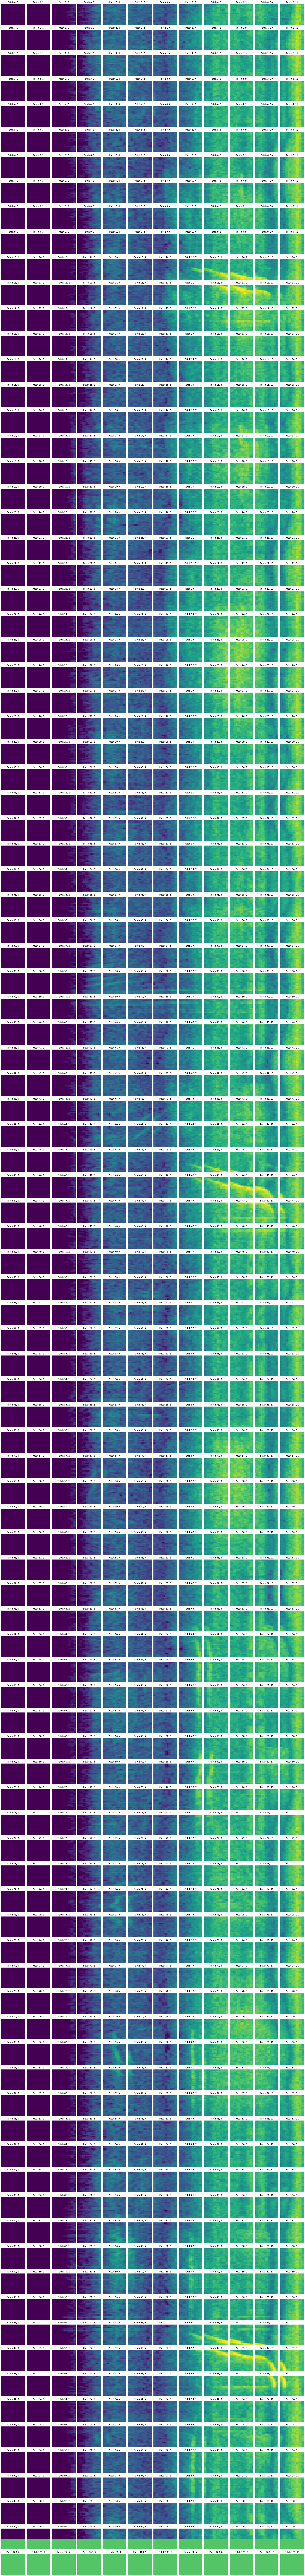

In [16]:
# Plot patches

time_dim = 101
freq_dim = 12

fig, axes = plt.subplots(time_dim, freq_dim, figsize=(freq_dim * 2, time_dim * 2))
patch_size = 16
for i in range(time_dim):
    for j in range(freq_dim):
        patch = spec_unpatched[0, i, j].cpu().numpy()
        ax = axes[i, j]
        ax.imshow(patch[0, :, :], aspect='auto',  vmax=1, vmin=-1)
        ax.set_title(f'Patch {i}, {j}')
        ax.axis('off') 

plt.tight_layout()
plt.show()

torch.Size([8, 101, 12, 3, 16, 16])


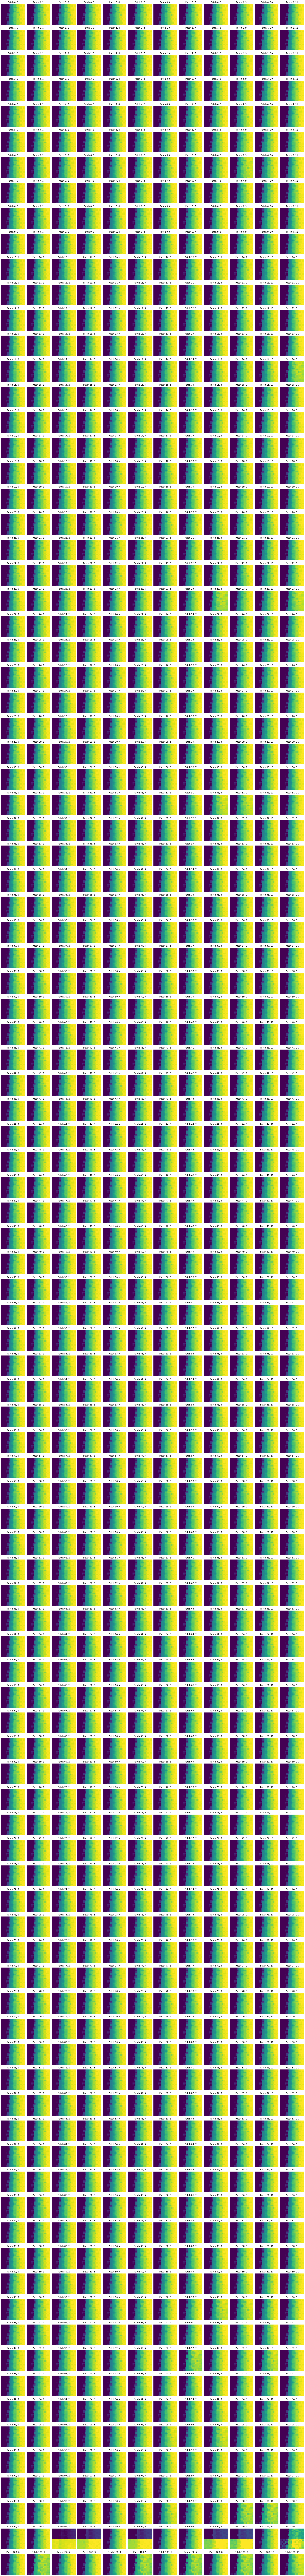

In [17]:
reconstructed_specs_unpatched = unpathify(reconstructed_spectrograms[:, 2:, :])

print(reconstructed_specs_unpatched.size())

fig, axes = plt.subplots(time_dim, freq_dim, figsize=(freq_dim * 2, time_dim * 2))
patch_size = 16
for i in range(time_dim):
    for j in range(freq_dim):
        patch = reconstructed_specs_unpatched[0, i, j].detach().cpu().numpy()
        ax = axes[i, j]
        ax.imshow(patch[0, :, :], aspect='auto',  vmax=1, vmin=-1)
        ax.set_title(f'Patch {i}, {j}')
        ax.axis('off') 

plt.tight_layout()
plt.show()

In [62]:
# coding=utf-8
# Copyright 2021 The HuggingFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Convert ViT and non-distilled DeiT checkpoints from the timm library."""

import argparse
from pathlib import Path

import requests
import timm
import torch
from PIL import Image
from timm.data import ImageNetInfo, infer_imagenet_subset

from transformers import DeiTImageProcessor, ViTConfig, ViTForImageClassification, ViTImageProcessor, ViTModel
from transformers.utils import logging

from transformers import ViTMAEConfig, ViTMAEForPreTraining, ViTMAEModel

logging.set_verbosity_info()
logger = logging.get_logger(__name__)


# here we list all keys to be renamed (original name on the left, our name on the right)
def create_rename_keys(config, base_model=False):
    rename_keys = []
    for i in range(config.num_hidden_layers):
        # encoder layers: output projection, 2 feedforward neural networks and 2 layernorms
        rename_keys.append((f"blocks.{i}.norm1.weight", f"vit.encoder.layer.{i}.layernorm_before.weight"))
        rename_keys.append((f"blocks.{i}.norm1.bias", f"vit.encoder.layer.{i}.layernorm_before.bias"))
        rename_keys.append((f"blocks.{i}.attn.proj.weight", f"vit.encoder.layer.{i}.attention.output.dense.weight"))
        rename_keys.append((f"blocks.{i}.attn.proj.bias", f"vit.encoder.layer.{i}.attention.output.dense.bias"))
        rename_keys.append((f"blocks.{i}.norm2.weight", f"vit.encoder.layer.{i}.layernorm_after.weight"))
        rename_keys.append((f"blocks.{i}.norm2.bias", f"vit.encoder.layer.{i}.layernorm_after.bias"))
        rename_keys.append((f"blocks.{i}.mlp.fc1.weight", f"vit.encoder.layer.{i}.intermediate.dense.weight"))
        rename_keys.append((f"blocks.{i}.mlp.fc1.bias", f"vit.encoder.layer.{i}.intermediate.dense.bias"))
        rename_keys.append((f"blocks.{i}.mlp.fc2.weight", f"vit.encoder.layer.{i}.output.dense.weight"))
        rename_keys.append((f"blocks.{i}.mlp.fc2.bias", f"vit.encoder.layer.{i}.output.dense.bias"))

    # projection layer + position embeddings
    rename_keys.extend(
        [
            ("cls_token", "vit.embeddings.cls_token"),
            ("patch_embed.proj.weight", "vit.embeddings.patch_embeddings.projection.weight"),
            ("patch_embed.proj.bias", "vit.embeddings.patch_embeddings.projection.bias"),
            ("pos_embed", "vit.embeddings.position_embeddings"),
        ]
    )

    if base_model:
        # layernorm
        rename_keys.extend(
            [
                ("norm.weight", "layernorm.weight"),
                ("norm.bias", "layernorm.bias"),
            ]
        )

        # if just the base model, we should remove "vit" from all keys that start with "vit"
        rename_keys = [(pair[0], pair[1][4:]) if pair[1].startswith("vit") else pair for pair in rename_keys]
    else:
        # layernorm + classification head
        rename_keys.extend(
            [
                ("norm.weight", "vit.layernorm.weight"),
                ("norm.bias", "vit.layernorm.bias"),
                ("head.weight", "classifier.weight"),
                ("head.bias", "classifier.bias"),
            ]
        )

    return rename_keys


# we split up the matrix of each encoder layer into queries, keys and values
def read_in_q_k_v(state_dict, config, base_model=False):
    for i in range(config.num_hidden_layers):
        if base_model:
            prefix = ""
        else:
            prefix = "vit."
        # read in weights + bias of input projection layer (in timm, this is a single matrix + bias)
        in_proj_weight = state_dict.pop(f"blocks.{i}.attn.qkv.weight")
        in_proj_bias = state_dict.pop(f"blocks.{i}.attn.qkv.bias")
        # next, add query, keys and values (in that order) to the state dict
        state_dict[f"{prefix}encoder.layer.{i}.attention.attention.query.weight"] = in_proj_weight[
            : config.hidden_size, :
        ]
        state_dict[f"{prefix}encoder.layer.{i}.attention.attention.query.bias"] = in_proj_bias[: config.hidden_size]
        state_dict[f"{prefix}encoder.layer.{i}.attention.attention.key.weight"] = in_proj_weight[
            config.hidden_size : config.hidden_size * 2, :
        ]
        state_dict[f"{prefix}encoder.layer.{i}.attention.attention.key.bias"] = in_proj_bias[
            config.hidden_size : config.hidden_size * 2
        ]
        state_dict[f"{prefix}encoder.layer.{i}.attention.attention.value.weight"] = in_proj_weight[
            -config.hidden_size :, :
        ]
        state_dict[f"{prefix}encoder.layer.{i}.attention.attention.value.bias"] = in_proj_bias[-config.hidden_size :]


def remove_classification_head_(state_dict):
    ignore_keys = ["head.weight", "head.bias"]
    for k in ignore_keys:
        state_dict.pop(k, None)


def rename_key(dct, old, new):
    val = dct.pop(old)
    dct[new] = val


# We will verify our results on an image of cute cats
def prepare_img():
    url = "http://images.cocodataset.org/val2017/000000039769.jpg"
    im = Image.open(requests.get(url, stream=True).raw)
    return im


@torch.no_grad()
def convert_vit_checkpoint(vit_name, pytorch_dump_folder_path):
    """
    Copy/paste/tweak model's weights to our ViT structure.
    """

    # define default ViT configuration
    config = ViTMAEConfig()
    base_model = False

    # load original model from timm
    timm_model = timm.create_model(vit_name, pretrained=True, num_classes=0)
    timm_model.eval()
    
    print(timm_model.num_classes)
    
    print(getattr(timm_model, "fc_norm", None), getattr(timm_model, "global_pool", None))

    # detect unsupported ViT models in transformers
    # fc_norm is present
    if not isinstance(getattr(timm_model, "fc_norm", None), torch.nn.Identity):
        raise ValueError(f"{vit_name} is not supported in transformers because of the presence of fc_norm.")

    # use of global average pooling in combination (or without) class token
    if getattr(timm_model, "global_pool", None) == "avg":
        raise ValueError(f"{vit_name} is not supported in transformers because of use of global average pooling.")

    # CLIP style vit with norm_pre layer present
    if "clip" in vit_name and not isinstance(getattr(timm_model, "norm_pre", None), torch.nn.Identity):
        raise ValueError(
            f"{vit_name} is not supported in transformers because it's a CLIP style ViT with norm_pre layer."
        )

    # SigLIP style vit with attn_pool layer present
    if "siglip" in vit_name and getattr(timm_model, "global_pool", None) == "map":
        raise ValueError(
            f"{vit_name} is not supported in transformers because it's a SigLIP style ViT with attn_pool."
        )

    # use of layer scale in ViT model blocks
    if not isinstance(getattr(timm_model.blocks[0], "ls1", None), torch.nn.Identity) or not isinstance(
        getattr(timm_model.blocks[0], "ls2", None), torch.nn.Identity
    ):
        raise ValueError(f"{vit_name} is not supported in transformers because it uses a layer scale in its blocks.")

    # Hybrid ResNet-ViTs
    if not isinstance(timm_model.patch_embed, timm.layers.PatchEmbed):
        raise ValueError(f"{vit_name} is not supported in transformers because it is a hybrid ResNet-ViT.")

    # get patch size and image size from the patch embedding submodule
    config.patch_size = (
        timm_model.patch_embed.patch_size[0],
        timm_model.patch_embed.patch_size[1]
        )
    config.image_size = (
        timm_model.patch_embed.img_size[0],
        timm_model.patch_embed.img_size[1]
        )

    # retrieve architecture-specific parameters from the timm model
    config.hidden_size = timm_model.embed_dim
    config.intermediate_size = timm_model.blocks[0].mlp.fc1.out_features
    config.num_hidden_layers = len(timm_model.blocks)
    config.num_attention_heads = timm_model.blocks[0].attn.num_heads
    config.num_channels = 1

    # check whether the model has a classification head or not
    if timm_model.num_classes != 0:
        config.num_labels = timm_model.num_classes
        # infer ImageNet subset from timm model
        imagenet_subset = infer_imagenet_subset(timm_model)
        dataset_info = ImageNetInfo(imagenet_subset)
        config.id2label = {i: dataset_info.index_to_label_name(i) for i in range(dataset_info.num_classes())}
        config.label2id = {v: k for k, v in config.id2label.items()}
    else:
        print(f"{vit_name} is going to be converted as a feature extractor only.")
        base_model = True

    # load state_dict of original model
    state_dict = timm_model.state_dict()

    # remove and rename some keys in the state dict
    if base_model:
        remove_classification_head_(state_dict)
    rename_keys = create_rename_keys(config, base_model)
    for src, dest in rename_keys:
        rename_key(state_dict, src, dest)
    read_in_q_k_v(state_dict, config, base_model)

    print(config)
    
    # load HuggingFace model
    if base_model:
        model = ViTMAEModel(config).eval()
    else:
        model = ViTForImageClassification(config).eval()
    model.load_state_dict(state_dict)

    # Check outputs on an image, prepared by ViTImageProcessor/DeiTImageProcessor
    if "deit" in vit_name:
        image_processor = DeiTImageProcessor(size=config.image_size)
    else:
        image_processor = ViTImageProcessor(size=config.image_size)
    encoding = image_processor(images=prepare_img(), return_tensors="pt")
    pixel_values = encoding["pixel_values"]
    outputs = model(pixel_values)

    if base_model:
        timm_pooled_output = timm_model.forward_features(pixel_values)
        assert timm_pooled_output.shape == outputs.last_hidden_state.shape
        assert torch.allclose(timm_pooled_output, outputs.last_hidden_state, atol=1e-1)
    else:
        timm_logits = timm_model(pixel_values)
        assert timm_logits.shape == outputs.logits.shape
        assert torch.allclose(timm_logits, outputs.logits, atol=1e-3)

    Path(pytorch_dump_folder_path).mkdir(exist_ok=True)
    print(f"Saving model {vit_name} to {pytorch_dump_folder_path}")
    model.save_pretrained(pytorch_dump_folder_path)
    print(f"Saving image processor to {pytorch_dump_folder_path}")
    image_processor.save_pretrained(pytorch_dump_folder_path)

vit_name = "hf_hub:gaunernst/vit_base_patch16_1024_128.audiomae_as2m"
convert_vit_checkpoint(vit_name, ".")

In [ ]:
1024//16 * 128//16

In [10]:
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.compliance import kaldi
from torchinfo import summary


# NOTE: for timm<0.9.11, you also need to pass `global_pool='avg'`
# if only embeddings are needed, pass `num_classes=0`
model = timm.create_model("hf_hub:gaunernst/vit_base_patch16_1024_128.audiomae_as2m", pretrained=True, num_classes=0)

# sub_model = nn.Sequential(*list(model.children())[0])
patch_embed = list(model.children())[0]

melspec = torch.randn(1, 1, 1024, 128)

output = patch_embed(melspec)

print(output.shape)

summary(model, input_size=(1, 1, 1024, 128))

torch.Size([1, 512, 768])


Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [1, 768]                  394,752
├─PatchEmbed: 1-1                        [1, 512, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 64, 8]           197,376
│    └─Identity: 2-2                     [1, 512, 768]             --
├─Dropout: 1-2                           [1, 513, 768]             --
├─Identity: 1-3                          [1, 513, 768]             --
├─Identity: 1-4                          [1, 513, 768]             --
├─Sequential: 1-5                        [1, 513, 768]             --
│    └─Block: 2-3                        [1, 513, 768]             --
│    │    └─LayerNorm: 3-1               [1, 513, 768]             1,536
│    │    └─Attention: 3-2               [1, 513, 768]             2,362,368
│    │    └─Identity: 3-3                [1, 513, 768]             --
│    │    └─Identity: 3-4                [1, 513, 768]           

0 cls_token torch.Size([1, 1, 768])
1 pos_embed torch.Size([1, 513, 768])
2 patch_embed.proj.weight torch.Size([768, 1, 16, 16])
3 patch_embed.proj.bias torch.Size([768])
4 blocks.0.norm1.weight torch.Size([768])
5 blocks.0.norm1.bias torch.Size([768])
6 blocks.0.attn.qkv.weight torch.Size([2304, 768])
7 blocks.0.attn.qkv.bias torch.Size([2304])
8 blocks.0.attn.proj.weight torch.Size([768, 768])
9 blocks.0.attn.proj.bias torch.Size([768])
10 blocks.0.norm2.weight torch.Size([768])
11 blocks.0.norm2.bias torch.Size([768])
12 blocks.0.mlp.fc1.weight torch.Size([3072, 768])
13 blocks.0.mlp.fc1.bias torch.Size([3072])
14 blocks.0.mlp.fc2.weight torch.Size([768, 3072])
15 blocks.0.mlp.fc2.bias torch.Size([768])
16 blocks.1.norm1.weight torch.Size([768])
17 blocks.1.norm1.bias torch.Size([768])
18 blocks.1.attn.qkv.weight torch.Size([2304, 768])
19 blocks.1.attn.qkv.bias torch.Size([2304])
20 blocks.1.attn.proj.weight torch.Size([768, 768])
21 blocks.1.attn.proj.bias torch.Size([768])
22 blo

In [ ]:
model

In [ ]:
from transformers import ViTMAEConfig, ViTMAEForPreTraining, ViTMAEModel

model_name = "gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k"

config = ViTMAEConfig.from_pretrained(model_name)
# model = ViTMAEForPreTraining.from_pretrained(model_name, config=config)
model = ViTMAEModel.from_pretrained(model_name, config=config)

In [ ]:
model

In [ ]:
print(timm.__version__)